# BigQuery

BigQuery is a NoSQL, column data structure, Data Warehouse. 

# Cost

In BigQuery, it doesn't cost you to create tables. It DOES, however, cost to store and query data. 
- Price per storage: https://cloud.google.com/bigquery/pricing#storage - it's approximately in the ballpark of 20 USD per terabyte per month


# Query optimisation

Optimising query cost:
- As it is a columnar database, `SELECT *` is the most expensive way to query data; so, **specify the exact columns you need** instead of using the wildcard `*` operator
- In partitioned and clustered tables, use `WHERE` on such columns
- Avoid query loops in BigQuery 

# Cluster and partition

https://cloud.google.com/bigquery/docs/clustered-tables

<img src="Media/cluster-partition.png">

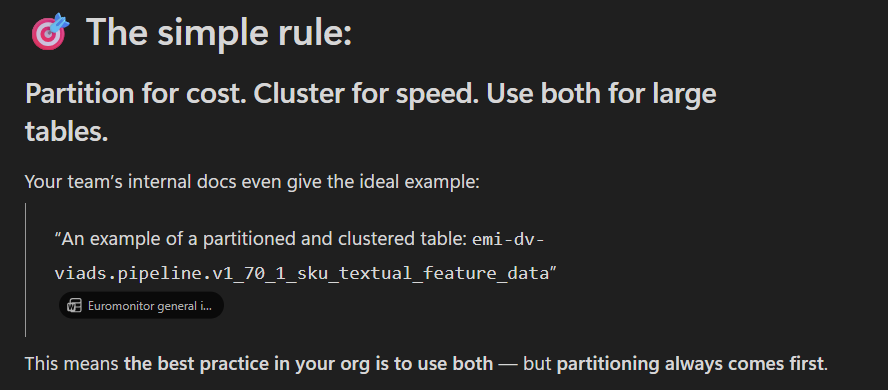

In [ ]:
/*
Create a partitioned / clustered table
More info: https://cloud.google.com/bigquery/docs/creating-partitioned-tables#sql
*/
CREATE OR REPLACE TABLE temp.ez_temp1 (
    id int64,
    transaction_date DATE
)
PARTITION BY transaction_date
CLUSTER BY (id)
AS 
SELECT 1 AS id, CAST('2023-01-01' AS DATE) AS year
UNION ALL
SELECT 2 AS id, CAST('2023-02-01' AS DATE) AS year 

## Partitioning

> Basically splitting a table into smaller tables

Partitioning is dividing a table into smaller tables based on a single column (date or integer).

Examples:
- A table containing sales data could be partitioned by month using the column containing the sale date, or by geographic region using the state/province code;
- It is a good pratice to partition by date

Types of partitioning:
- Horizontal: assigning rows to different partitions;
- Vertical: assigning sets of columns to different partitions (must be done manually);

When partitioning a table horizontally, you must choose a **partition key** - a column whose values are used to assign a row to a particular partition. 

Partitioning methods:
- Range partitioning: 
  - break up tables by date ranges;
  - Allows for a maxvalue partition to catch any rows that don't map to any other partition
- List: 
  - allows you to specify which values will be assigned to each partition
  - Can be used with enumerated set of values, e.g. state codes (CA, TX, VA), currencies (USD, EUR, JPY)
  - doesn't provide for a spillover partition (to catch any rows that don't map to any other partition)
  - the column chosen as the partitioning key should contain only a small number of values
- Hash partitioning:
  - tries to distribute rows evenly across a set of partitions by applying a hashing function to the column value 
  - Hash partitioning works best when the partitioning key column contains a large number of distinct values
- Composite partitioning: 
  - Allows you to use two different types of partitioning for the same table

Check partitions - MySQL:

```sql
SELECT
    partition_name,
    partition_expression,
    partition_description
FROM information_schema.partitions
WHERE table_name = 'sales'
ORDER BY partition_ordinal_position;
```

Benefits:
- Partition pruning: You may only need to interact with as few as one partition instead of the entire table; 
- Partition-wise joins: if you execute a query that includes a join to a partitioned table and the query includes a condition on the partitioning column, the server can exclude any partitions that do not contain data pertinent to the query;
- An ability to delete data that is no longer needed, e.g. deleting a partition that is older than seven years old; 

Disadvantages:
- There is a hard number of partitions - A table cannot be partitioned into an infinite number of partitions

## Clustering

> Basically it's just sorting

Clustering: 
- Basically just sorting by values in up to 4 columns
- Improves performance of some queries with filter and aggregate clauses
- Better done when cardinality of values in a column or group of columns is large

## Sharding

Partition the data across multiple databases; 

for example, if you were to employ this strategy for a social media company, you might decide to implement 100 separate databases, each one hosting the data for approximately 10 million users. 

# Operations

## Copy the table

In [ ]:
CREATE OR REPLACE TABLE `project.dataset.table2`
AS
SELECT *
FROM `project.dataset.table1`;

## Check if table exists

In [ ]:
-- If you already specified your project
SELECT size_bytes FROM `<dataset>.__TABLES__` WHERE table_id = '<name-of-your-table-here>'
-- You can also specify the project
SELECT size_bytes FROM `<project>.<dataset>.__TABLES__` WHERE table_id = '<name-of-your-table-here>'

In [ ]:
-- Analogously, you can search for tables with regex match for name
SELECT * FROM `emi-lv-viads.public.__TABLES__` WHERE table_id LIKE '%preproc%'


# Some API calls

In [ ]:
from google.cloud import bigquery

bq_client = bigquery.Client(
    location="eu",
    project="<project name here>",
    default_query_job_config=bigquery.QueryJobConfig(
        labels={
            "<key 1>": "<label 1>", 
            "<key 2>": "<label 2>"}
    ),
)

In [ ]:
# For a given Pandas dataframe, create and upload its contents to a BigQuery table

bq_client.load_table_from_dataframe(
    df,
    f"<dataset>.<table>",
    job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE"),
).result()


In [ ]:
# Update description of a table (or set a new value)
import pandas as pd

attribute_labels = pd.read_csv('../input/brands.csv')
pandas_gbq.to_gbq(
    attribute_labels, 
    f"temp.check", 
    project_id = 'emi-dv-cgds', 
    if_exists = 'replace'
)

table = client.get_table('temp.check')
table.description = 'Description here.'
client.update_table(table, ['description'])


## Magics

In [ ]:
from google.cloud import bigquery
from google.cloud.bigquery.magics import magics

bigquery.magics.context.default_query_job_config.labels = {
    'service': 'service_here',
    'activity': 'activity_here'
}
%load_ext bigquery_magics

In [ ]:
%%bigquery
SELECT *
FROM `database.table1`
WHERE id = 1

# Practice datasets

You can be in the Sandbox mode, which is with disabled payment. 

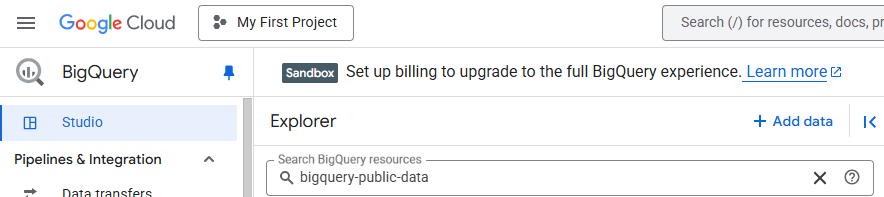

In [ ]:
/*
You can practice with the dataset `bigquery-public-data`, table `ga4_obfuscated_sample_ecommerce`
*/
SELECT COUNT(*)
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`


In [ ]:
WITH temp1 AS (
  SELECT 
    items.item_name AS item_name,
    items.item_id AS item_id, 
    items.item_brand AS item_brand,
    items.item_category AS item_category,
    items.price AS item_price,
    SUM(
      CASE WHEN event_name = 'purchase' THEN 1 
      ELSE 0
      END
    ) AS purchases,
    user_pseudo_id
  FROM 
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`,
    UNNEST (items) AS items
  WHERE
    NOT (item_category = '' OR item_category = '(not set)')
    AND event_name = 'purchase'
    AND _TABLE_SUFFIX BETWEEN '2021-01-04' AND '2021-01-31'
  GROUP BY 1, 2, 3, 4, 5, 7
)

SELECT
  item_name,
  item_id, 
  item_brand, 
  item_category, 
  item_price, 
  SUM(purchases) AS purchases,
  COUNT(DISTINCT user_pseudo_id) AS total_users
FROM temp1 
GROUP BY 1, 2, 3, 4, 5



In [ ]:
import pandas as pd
import numpy as np
from google.cloud import bigquery

bq_client = bigquery.Client() 

query = """
SELECT COUNT(*)
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
"""

df = bq_client.query(query).to_dataframe()
df

c:\Users\evgen\.conda\envs\data-science-2\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,f0_
0,4295584


In [5]:
import pandas as pd
import numpy as np
from google.cloud import bigquery

bq_client = bigquery.Client() 

query = """
WITH temp1 AS (
  SELECT 
    items.item_name AS item_name,
    items.item_id AS item_id, 
    items.item_brand AS item_brand,
    items.item_category AS item_category,
    items.price AS item_price,
    SUM(
      CASE WHEN event_name = 'purchase' THEN 1 
      ELSE 0
      END
    ) AS purchases,
    user_pseudo_id
  FROM 
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`,
    UNNEST (items) AS items
  WHERE
    NOT (item_category = '' OR item_category = '(not set)')
    AND event_name = 'purchase'
    -- AND _TABLE_SUFFIX BETWEEN '2025-05-01' AND '2025-12-31'
  GROUP BY 1, 2, 3, 4, 5, 7
)

SELECT
  item_name,
  item_id, 
  item_brand, 
  item_category, 
  item_price, 
  SUM(purchases) AS purchases,
  COUNT(DISTINCT user_pseudo_id) AS total_users
FROM temp1 
GROUP BY 1, 2, 3, 4, 5
"""

df = bq_client.query(query).to_dataframe()
df



c:\Users\evgen\.conda\envs\data-science-2\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,item_name,item_id,item_brand,item_category,item_price,purchases,total_users
0,Google Blue Stojo Cup,9199127,Google,Shop by Brand,20.0,32,28
1,Google Black Cloud Zip Hoodie,9200322,Google Cloud,Apparel,55.0,10,8
2,Google Summer19 Crew Grey,9195920,Google,Apparel,43.0,1,1
3,Google NYC Campus Mug,9196950,Google,Campus Collection,7.0,84,77
4,Google Large Tote White,9195959,Google,Bags,10.0,61,58
...,...,...,...,...,...,...,...
1325,Google Heather Green Speckled Tee,9196620,Google,Apparel,24.0,1,1
1326,Google Heather Green Speckled Tee,9196621,Google,Apparel,30.0,1,1
1327,Google Women's Grid Zip-Up,9194991,Google,Apparel,50.0,1,1
1328,Google PNW Campus Zip Hoodie,9197708,Google,Clearance,41.0,1,1
